# Matt and Paul's Notebook

## 1a. Packages and Libraries Import

In [1]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

## 1b. Load Dataset

In [2]:
df = pd.read_csv('data/regularseason17.csv').drop('Unnamed: 0', axis = 1)

X = df.drop('fav_win',axis=1)
y = df['fav_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((4147, 106), (1037, 106))

In [3]:
y.value_counts(normalize=True)

True     0.747685
False    0.252315
Name: fav_win, dtype: float64

## 2. Function Builds for Project

### 2a. Data Scaling

In [4]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [5]:
len(X_test_scaled)

1037

In [6]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [7]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [8]:
def feature_select(X_train,y_train,estimator,min_features,step=1):
    estimator2=estimator()
    selector=RFECV(estimator2,min_features_to_select=min_features,step=step)
    selector.fit(X_train,y_train)
    selector.ranking_
    feature_dict=dict(zip(X_train.columns, selector.ranking_))
    best_pred = [k for (k,v) in feature_dict.items() if v == 1]
    
    
    return best_pred

In [9]:
log_feat=feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[log_feat]
X_test_best_log = X_test_scaled[log_feat]

In [10]:
len(X_test_best_log)

1037

In [11]:
y_train = y_train.reset_index(drop=True)
y_train

0        True
1       False
2        True
3        True
4        True
        ...  
4142     True
4143    False
4144     True
4145     True
4146     True
Name: fav_win, Length: 4147, dtype: bool

### 2b. Logistic Regression Model

In [12]:
# Used to look at statistically significant coefficients
# but not needed for coding purposes

# log_reg_sum = sm.Logit(y_train, X_train_best_log).fit()
# print(log_reg_sum.summary())

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [13]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    grid_logreg.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Instantiate & fit LogReg model
    log = LogisticRegression(random_state=42, penalty=logreg_penalty, solver=logreg_solver)
    log.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = log.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(log, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = log.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = log.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(log, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(log, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(log, X_train, y_train)
    plot_confusion_matrix(log, X_test, y_test)

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.8485723836237593
Train Mean Accuracy: 0.8536291294911984
Test Mean Accuracy: 0.8601735776277725
Recall Score: 0.9434954007884363
Precision Score: 0.875609756097561
F1 Score: 0.9082858950031626


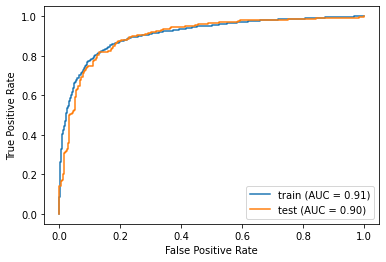

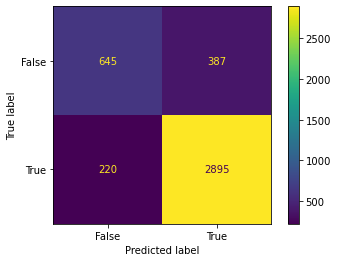

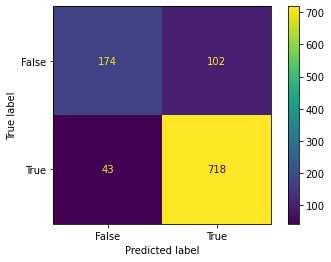

In [14]:
logreg(X_train_best_log, X_test_best_log, y_train, y_test)

### 2c. K-Nearest Neighbors Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [17]:
def knn(X_train, X_test, y_train, y_test, metric='minkowski', cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_neighbors': [5,7,9,11,13,15,17],
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']}
    
    # Instantiate & fit KNN model for GridSearch
    grid_knn = KNeighborsClassifier()
    grid_knn.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_knn, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    knn_params = gs.best_params_
    
    # Use best # of neighbors from best_params
    knn_neighbors = knn_params['n_neighbors']
    print(f'Number of Neighbors: {knn_neighbors}')
    
    # Use best metric from best_params
    knn_metric = knn_params['metric']
    print(f'Metric: {knn_metric}')
    
    # Use best weights from best_params
    knn_weights=knn_params['weights']
    print(f'Weights: {knn_weights}')
    
    # Instantiate & fit K-Nearest Neighbors model
    knn = KNeighborsClassifier(n_neighbors=knn_neighbors, metric=knn_metric,
                               weights=knn_weights)
    knn.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = knn.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(knn, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = knn.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = knn.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(knn, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(knn, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(knn, X_train, y_train)
    plot_confusion_matrix(knn, X_test, y_test)

Number of Neighbors: 7
Metric: minkowski
Weights: distance
Mean Cross-Val Score: 0.8422971499992734
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.845708775313404
Recall Score: 0.9579500657030223
Precision Score: 0.8506417736289381
F1 score: 0.9011124845488256


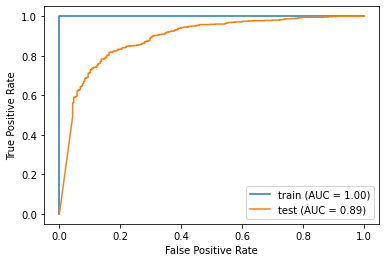

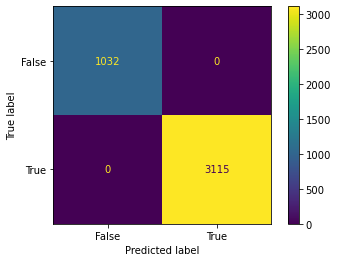

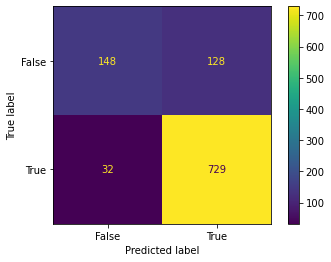

In [18]:
knn(X_train_scaled, X_test_scaled, y_train, y_test)

In [35]:
dtree_feats=feature_select(X_train_scaled,y_train,DecisionTreeClassifier,min_features=10)

In [36]:
X_train_best_dtree=X_train[dtree_feats]
X_test_best_dtree=X_test[dtree_feats]

In [ ]:
# # GridSearchCV alternative coded by hand (not to be used)
# knn_dict={}
# for index in range(1,33,2):
#     knn_model = KNeighborsClassifier(n_neighbors=index)
#     knn_log_loss = -1 * cross_val_score(knn_model, X_train,
#                                         y_train, scoring="accuracy").mean()
#     knn_dict[index] = knn_log_loss
# min_knn = min(knn_dict.values())
# low_key = list(knn_dict.keys())[list(knn_dict.values()).index(min_knn)]
# knn = KNeighborsClassifier(n_neighbors=low_key,metric=metric)

### 2d. Decision Tree Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [37]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    dt_params = gs.best_params_
    
    # Use best max depth from best_params
    dt_max_depth = dt_params['max_depth']
    print(f'Max Depth: {dt_max_depth}')
    
    # Use best minimum sample split from best_params
    dt_min_samp = dt_params['min_samples_split']
    print(f'Min Sample Split: {dt_min_samp}')
    
    # Use best criterion from best_params
    dt_criterion = dt_params['criterion']
    print(f'criterion: {dt_criterion}')
    
    # Instantiate & fit Decision Tree model
    dtree = DecisionTreeClassifier(max_depth=dt_max_depth, criterion=dt_criterion,
                                   min_samples_split=dt_min_samp, random_state=42)
    dtree.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = dtree.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(dtree, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = dtree.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = dtree.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(dtree, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(dtree, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(dtree, X_train, y_train)
    plot_confusion_matrix(dtree, X_test, y_test)

Max Depth: 15
Min Sample Split: 2
criterion: entropy
Mean Cross-Val Score: 0.7851529640879562
Train Mean Accuracy: 0.9990354473113093
Test Mean Accuracy: 0.7695274831243973
Recall Score: 0.8436268068331143
Precision Score: 0.84251968503937
F1 score: 0.8430728824688114


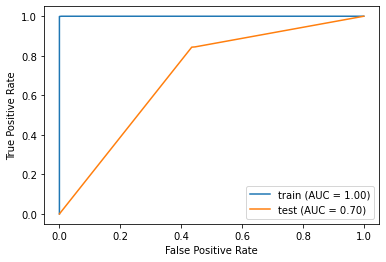

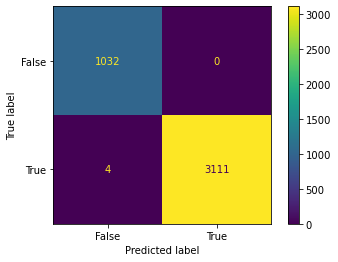

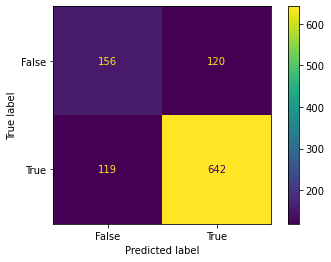

In [38]:
#Took 14 min to run
dtree(X_train_best_dtree, X_test_best_dtree, y_train, y_test)

### 2e. Random Forest Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [44]:
random_forest_feat=feature_select(X_train_scaled,y_train,RandomForestClassifier,min_features=10)
X_train_best_rforest=X_train_scaled[random_forest_feat]
X_test_best_rforest=X_test_scaled[random_forest_feat]

In [45]:
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    grid_rf.fit(X_train,y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    rf_params = gs.best_params_
    
    # Use best # of trees from best_params
    rf_n_estimators = rf_params['n_estimators']
    print(f'Number of Trees: {rf_n_estimators}')
    
    # Use best criterion from best_params
    rf_criterion = rf_params['criterion']
    print(f'criterion: {rf_criterion}')
    
    # Instantiate & fit Random Forest model
    rforest = RandomForestClassifier(n_estimators=rf_n_estimators, criterion=rf_criterion,
                                    random_state=42)
    rforest.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = rforest.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(rforest, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = rforest.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = rforest.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(rforest, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(rforest, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(rforest, X_train, y_train)
    plot_confusion_matrix(rforest, X_test, y_test);

Number of Trees: 110
criterion: entropy
Mean Cross-Val Score: 0.8521842254421788
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.845708775313404
Recall Score: 0.9632063074901446
Precision Score: 0.8473988439306358
F1 score: 0.9015990159901599


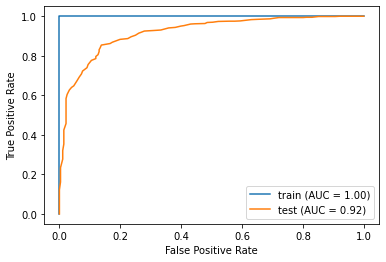

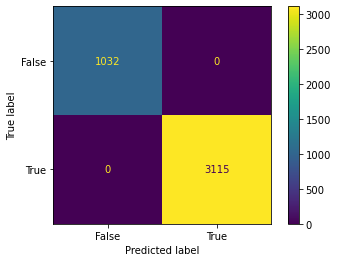

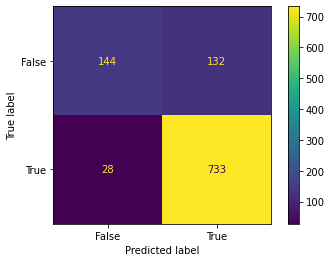

In [46]:
# Takes 1 hour and 6 minutes
random_forest(X_train_best_rforest, X_test_best_rforest, y_train, y_test, cv=5)

### 2f. Bagging Classifier Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [37]:
def bagged(X_train, X_test, y_train, y_test, cv=5):

    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'base_estimator__max_depth': [2,5,15],
    'base_estimator__criterion': ['gini', 'entropy'],
    'max_samples': [1,2,3,5],
    'max_features': [1,2,3,5],
    'n_estimators': [10,50,100,500]}
    
    # Instantiate & fit Bagging Classifier model for GridSearch
    grid_bag = BaggingClassifier(DecisionTreeClassifier(), random_state=42)
    grid_bag.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_bag, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    bag_params = gs.best_params_
    
    # Use best max depth from best_params
    bag_max_depth = bag_params['base_estimator__max_depth']
    print(f'Dec Tree Max Depth: {bag_max_depth}')
    
    # Use best criterion from best_params
    bag_criterion = bag_params['base_estimator__criterion']
    print(f'Dec Tree Criterion: {bag_criterion}')
    
    # Use best max samples from best_params
    bag_max_sample = bag_params['max_samples']
    print(f'Bagging Max Samples: {bag_max_sample}')
    
    # Use best max features from best_params
    bag_max_features = bag_params['max_features']
    print(f'Bag Max Features: {bag_max_features}')
    
    # Use best estimators from best_params
    bag_estimators = bag_params['n_estimators']
    print(f'# of Base Estimators: {bag_estimators}')
    
    # Instantiate & fit Bagging Classifier model
    bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=bag_max_depth,
                                criterion=bag_criterion), max_samples=bag_max_sample,
                                max_features=bag_max_features, n_estimators=bag_estimators,
                                random_state=42)
    bagging.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = bagging.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(bagging, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = bagging.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = bagging.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(bagging, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(bagging, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(bagging, X_train, y_train)
    plot_confusion_matrix(bagging, X_test, y_test);

Dec Tree Max Depth: 2
Dec Tree Criterion: gini
Bagging Max Samples: 1
Bag Max Features: 1
# of Base Estimators: 10
Mean Cross-Val Score: 0.7511456683186303
Train Mean Accuracy Score: 0.7511454063178201
Test Mean Accuracy Score: 0.733847637415622
Recall Score: 1.0
Precision Score: 0.733847637415622
F1 score: 0.8464961067853171


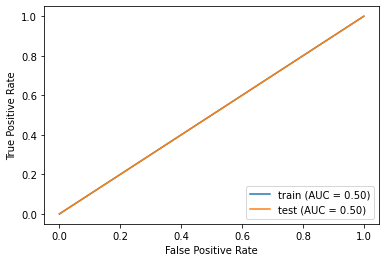

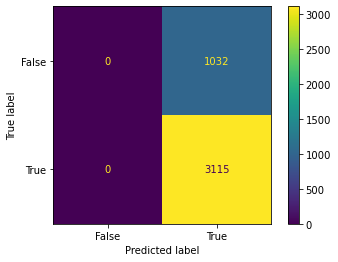

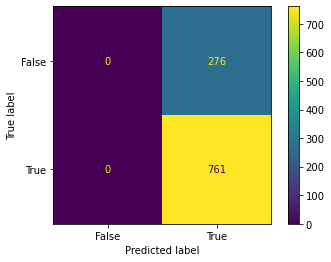

In [38]:
# Takes about 7-10 minutes to run
bagged(X_train, X_test, y_train, y_test, cv=5)

### 2g. Gradient Booster Classifier Model

In [39]:
def grad_boost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,5,10,15],
    'min_samples_split': [2,3,5,10,15],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [.01,.05,.1,.2],
    'n_estimators': [100,300,500],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']}
    
    # Instantiate & fit Bagging Classifier model for GridSearch
    grad = GradientBoostingClassifier(random_state=42)
    grad.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grad, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    grad_params = gs.best_params_
    
    # Use best max depth from best_params
    grad_max_depth = grad_params['max_depth']
    print(f'Gradient Boost Max Depth: {grad_max_depth}')
    
    # Use best minimum sample split from best_params
    grad_min_sample = grad_params['min_samples_split']
    print(f'Gradient Boost Min Sample Split: {grad_min_sample}')
    
    # Use best loss from best_params
    grad_loss = grad_params['loss']
    print(f'Gradient Boost Loss: {grad_loss}')
    
    # Use best learning rate from best_params
    grad_learning_rate = grad_params['learning_rate']
    print(f'Gradient Boost Learning Rate: {grad_learning_rate}')
    
    # Use best estimators from best_params
    grad_estimators = grad_params['n_estimators']
    print(f'Gradient Boost Estimators: {grad_estimators}')
    
    # Use best criterion from best_params
    grad_criterion = grad_params['criterion']
    print(f'# of Base Estimators: {grad_criterion}')
    
    # Instantiate & fit Gradient Booster model
    g_boost = GradientBoostingClassifier(max_depth=grad_max_depth, min_samples_split=grad_min_sample,
                                         loss=grad_loss, learning_rate=grad_learning_rate,
                                         n_estimators=grad_estimators, criterion=grad_criterion,
                                         random_state=42)
    g_boost.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = g_boost.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(g_boost, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = g_boost.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = g_boost.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(g_boost, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(g_boost, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(g_boost, X_train, y_train)
    plot_confusion_matrix(g_boost, X_test, y_test);

In [42]:
grad_boost(X_train, X_test, y_train, y_test, cv=5)

KeyboardInterrupt: 

### 2h. XGBoost Model

In [49]:
xgboost_feat=feature_select(X_train_scaled,y_train,XGBClassifier,min_features=10)

KeyboardInterrupt: 

In [ ]:
X_train_feat_xgboost=X_train_scaled[xgboost_feat]
X_test_feat_xgboost=X_test_scaled[xgboost_feat]

In [ ]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.05,.1,.2,.3],
    'max_depth': [3,6,10],
    'min_child_weight': [1,2],
    'subsample': [.5,.7,1],
    'n_estimators': [100,300,500],
    'early_stopping_rounds': [15]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    xgb_params = gs.best_params_
    
    # Use best learning rate from best_params
    xgb_lr = xgb_params['learning_rate']
    print(f'XGBoost Learning Rate: {xgb_lr}')
    
    # Use best max depth from best_params
    xgb_max_depth = xgb_params['max_depth']
    print(f'XGBoost Max Depth: {xgb_max_depth}')
    
    # Use best min child weight from best_params
    xgb_min_child_weight = xgb_params['min_child_weight']
    print(f'XGBoost Min Child Weight: {xgb_min_child_weight}')
    
    # Use best subsample from best_params
    xgb_subsample = xgb_params['subsample']
    print(f'XGBoost Subsample: {xgb_subsample}')
    
    # Use best estimators from best_params
    xgb_estimators = xgb_params['n_estimators']
    print(f'XGBoost Estimators: {xgb_estimators}')
    
    # Use best criterion from best_params
    xgb_stop = xgb_params['early_stopping_rounds']
    print(f'Stopped in Round: {xgb_stop}')
    
    # Create prediction variable using test data
    y_pred = xgb.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(xgb, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = xgb.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = xgb.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(xgb, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(xgb, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(xgb, X_train, y_train)
    plot_confusion_matrix(xgb, X_test, y_test);

In [ ]:
xgboost(X_train, X_test, y_train, y_test, cv=5)